In [1]:
import keras
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


In [0]:
test_labels = y_test.T[0]
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [0]:
import numpy as np
import tensorflow as tf

In [0]:
def normalization(images):
    images = images.reshape(-1, 3072)
    each_pixel_mean = images.mean(axis=0)
    each_pixel_std = np.std(images, axis=0)
    images = np.divide(np.subtract(images, each_pixel_mean), each_pixel_std)
    return images.reshape(-1, 32, 32, 3)

In [0]:
train_pixels, one_hot_train_labels = normalization(x_train), y_train
test_pixels, one_hot_test_labels = normalization(x_test), y_test

In [0]:
def new_batch():
    train_index = 0
    def get_batch(total_x, total_y, batch_size):
        nonlocal train_index
        num = total_x.shape[0]
        start = train_index
        train_index += batch_size
        # shuffle training data when all data has been used
        if train_index > num:
            start = 0
            train_index = batch_size
            re_order = np.random.shuffle(np.arange(num))
            total_x = total_x[re_order][0]
            total_y = total_y[re_order][0]
        end = train_index
        return total_x[start:end], total_y[start:end]
    return get_batch

In [0]:
def conv2d_maxpool(x_tensor, conv_output_num):
    W_shape = [3, 3] + [int(x_tensor.shape[3]), conv_output_num]
    W = tf.Variable(tf.truncated_normal(W_shape, stddev=.05))
    x = tf.nn.conv2d(x_tensor, W, strides=[1, 1, 1, 1], padding='SAME')
    b = tf.Variable(tf.zeros([conv_output_num]))
    x = tf.nn.bias_add(x, b)
    x = tf.nn.relu(x)
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def dense(x_tensor, output_num):
    W = tf.Variable(tf.truncated_normal([int(x_tensor.shape[1]), output_num], stddev=.05))
    b = tf.Variable(tf.zeros([output_num]))
    return tf.add(tf.matmul(x_tensor, W), b)

def CNN(x_tensor, keep_prob):
    x = conv2d_maxpool(x_tensor, 64)
    x = conv2d_maxpool(x, 128)
    x = conv2d_maxpool(x, 256)
    x = tf.nn.dropout(x, keep_prob)
    x = tf.reshape(x, [-1, np.prod(x.shape.as_list()[1:])])
    x = dense(x, 1024)
    x = tf.nn.relu(x)
    x = tf.nn.dropout(x, keep_prob)
    x = dense(x, 512)
    x = tf.nn.relu(x)
    x = tf.nn.dropout(x, keep_prob)
    return dense(x, 10)

In [8]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, 32, 32, 3], name="x")
y = tf.placeholder(tf.float32, [None, 10], name="y")
keep_prob = tf.placeholder(tf.float32, name="keep_prob")
cifar10 = CNN(x, keep_prob)
cifar10 = tf.identity(cifar10, name='cifar10')
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=cifar10, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)
prediction = tf.argmax(cifar10, 1)
correct_pred = tf.equal(prediction, tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [0]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
epochs = 1901
batch_size = 1024
keepProb = 0.5
iter_display = 1
get_new_batch = new_batch()

In [10]:
for i in range(epochs):
    batch_x, batch_y = get_new_batch(train_pixels, one_hot_train_labels, batch_size)
    if (i % iter_display) == 0 or i == (epochs-1):
        if (i == 10 or i == 100) and iter_display < 100:
            iter_display *= 10
        train_accuracy = accuracy.eval(feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        test_accuracy = accuracy.eval(feed_dict={x: test_pixels, y: one_hot_test_labels, keep_prob: 1.0})
        print('Epoch %d: training accuracy=%.2f, test_accuracy=%.2f' % (i, train_accuracy, test_accuracy))
    sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: keepProb})

Epoch 0: training accuracy=0.08, test_accuracy=0.08
Epoch 1: training accuracy=0.13, test_accuracy=0.13
Epoch 2: training accuracy=0.17, test_accuracy=0.16
Epoch 3: training accuracy=0.19, test_accuracy=0.20
Epoch 4: training accuracy=0.22, test_accuracy=0.21
Epoch 5: training accuracy=0.21, test_accuracy=0.20
Epoch 6: training accuracy=0.20, test_accuracy=0.20
Epoch 7: training accuracy=0.19, test_accuracy=0.21
Epoch 8: training accuracy=0.22, test_accuracy=0.21
Epoch 9: training accuracy=0.23, test_accuracy=0.22
Epoch 10: training accuracy=0.21, test_accuracy=0.22
Epoch 20: training accuracy=0.31, test_accuracy=0.31
Epoch 30: training accuracy=0.35, test_accuracy=0.37
Epoch 40: training accuracy=0.41, test_accuracy=0.41
Epoch 50: training accuracy=0.42, test_accuracy=0.42
Epoch 60: training accuracy=0.45, test_accuracy=0.47
Epoch 70: training accuracy=0.51, test_accuracy=0.50
Epoch 80: training accuracy=0.49, test_accuracy=0.51
Epoch 90: training accuracy=0.52, test_accuracy=0.54
Epo

In [0]:
predict_labels = prediction.eval(feed_dict={x: test_pixels, y: one_hot_test_labels, keep_prob: 1.0})

In [12]:
def confusion_matrix(actual, predict):
    cmatrix = np.zeros((10, 10)).astype(int)
    for i in range(10000):
        if actual[i] == predict[i]:
            cmatrix[actual[i]][actual[i]] += 1
        else:
            cmatrix[actual[i]][predict[i]] += 1
    return cmatrix

cm = confusion_matrix(test_labels, predict_labels)
print(cm)
print("Accuracy = {:>6.4f}".format(cm.diagonal().sum()*1.0/cm.sum()))

[[822  21  30  12   9   3   9   9  60  25]
 [  6 913   4   3   1   2   2   2  17  50]
 [ 52   3 744  30  58  27  57  16   8   5]
 [ 20  10  61 593  58 136  64  21  20  17]
 [ 12   4  63  40 768  17  50  35   8   3]
 [ 10   3  43 120  40 719  25  26   5   9]
 [  3   6  28  24  17  15 899   1   5   2]
 [ 10   5  23  23  42  44   8 833   3   9]
 [ 22  15   6   3   2   2   5   4 920  21]
 [ 20  51   4   5   1   3   6   3  20 887]]
Accuracy = 0.8098


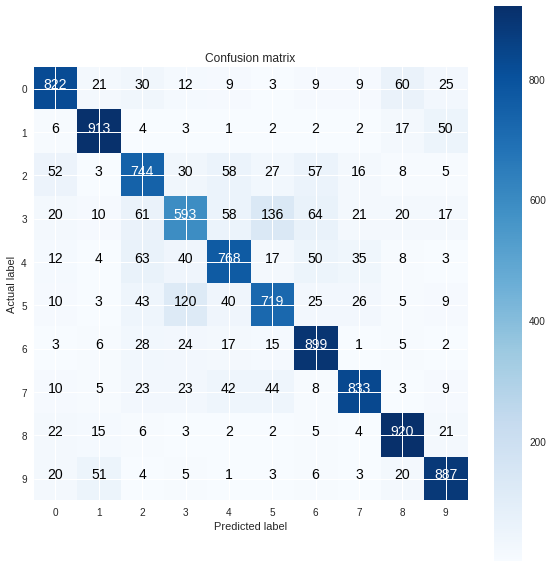

In [13]:
import math
import matplotlib.pyplot as plt
import numpy as np
import itertools
%matplotlib inline

def plot_confusion_matrix(cm, label_num):
    labels = range(label_num)
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    marks = np.arange(len(labels))
    plt.xticks(marks, labels)
    plt.yticks(marks, labels)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, int(cm[i, j]), fontsize=14,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
plot_confusion_matrix(cm, 10)

In [14]:
def evaluation(cmatrix):
    print("|  Label  | Precision | Recall | F-Score |")
    total_p = 0
    total_r = 0
    total_f = 0
    for i in range(10):
        precision = cmatrix[i, i]*1.0/cmatrix[:, i].sum()
        recall = cmatrix[i, i]*1.0/cmatrix[i, :].sum()
        fscore = precision*recall*2.0/(precision+recall)
        total_p += precision
        total_r += recall
        total_f += fscore
        print('|{:>8d} | {:>9.4f} | {:>6.4f} | {:>7.4f} |'.format(i, precision, recall, fscore))
    print('| Average | {:>9.4f} | {:>6.4f} | {:>7.4f} |'.format(total_p/10.0, total_r/10.0, total_f/10.0))

evaluation(cm)

|  Label  | Precision | Recall | F-Score |
|       0 |    0.8414 | 0.8220 |  0.8316 |
|       1 |    0.8855 | 0.9130 |  0.8991 |
|       2 |    0.7396 | 0.7440 |  0.7418 |
|       3 |    0.6952 | 0.5930 |  0.6400 |
|       4 |    0.7711 | 0.7680 |  0.7695 |
|       5 |    0.7428 | 0.7190 |  0.7307 |
|       6 |    0.7991 | 0.8990 |  0.8461 |
|       7 |    0.8768 | 0.8330 |  0.8544 |
|       8 |    0.8630 | 0.9200 |  0.8906 |
|       9 |    0.8628 | 0.8870 |  0.8748 |
| Average |    0.8077 | 0.8098 |  0.8079 |


In [0]:
sess.close()